# Local Setup Instructions

## Prerequisites Checklist

Before running this notebook, ensure you have completed the following setup:

- [ ] **Java 11 installed** and `JAVA_HOME` configured
  - macOS: `brew install openjdk@11`
  - Set: `export JAVA_HOME=$(/usr/libexec/java_home -v 11)`
- [ ] **Conda environment `fraud-shield` created and activated**
  - Create: `conda env create -f environment.yml`
  - Activate: `conda activate fraud-shield`
- [ ] **Data directories created**
  - `data/processed/` - for preprocessed data
  - `models/` - for saved models
  - `results/` - for model results
- [ ] **Preprocessed data available**
  - Run `02-local-preprocessing.ipynb` first
  - Preprocessed data should exist in `data/processed/`

## Environment Activation

```bash
conda activate fraud-shield
```

## Data Requirements

This notebook requires preprocessed data from the preprocessing notebook:
- `data/processed/train_preprocessed.parquet`
- `data/processed/val_preprocessed.parquet`
- `data/processed/test_preprocessed.parquet`

**Note:** This is a local execution version configured for the `fraud-shield` conda environment on your local machine.

# Supervised Models for Fraud Detection - Local Execution Version

**Notebook:** 04-local-supervised-models.ipynb  
**Objective:** Train and evaluate XGBoost with iterative feature addition; select best model by validation F1; save model and results.

**Note:** Local execution - conda environment `fraud-shield`

## Pipeline

1. **Load** train/val/test from `data/processed/`; define `feature_cols` (e.g. 24 numeric columns).
2. **Define feature sets** (Section 2: priority lists if names match; else unused). **Build feature sets** from `feature_cols`: Top 3, 5, 7, 10, 15, 20, All.
3. **Baseline:** XGBoost with first 7 features; `scale_pos_weight` for imbalance; evaluate Train/Val/Test (F1, PR-AUC, ROC-AUC, confusion matrix).
4. **Iterative addition:** Train XGBoost for each feature set; compare validation F1; best model = All (24 features) in typical runs.
5. **Save:** Best model, metadata, comparison CSV and results to `models/` and `results/`.

## Results (typical run)

- **Validation:** F1 and PR-AUC improve with more features (e.g. Val F1 0.28, PR-AUC 0.46, ROC-AUC 0.93 for All).
- **Test:** F1 and PR-AUC stay very low (~0.007 and ~0.02); test confusion matrix shows almost all samples predicted positive (FPR ~100%, precision ~0.004). ROC-AUC on test is moderate (e.g. 0.73) but does not reflect usable precision/recall at default threshold.

## Interpretation / Rationality

**Default threshold 0.5 is wrong here.** Train fraud rate ~9% (SMOTE), val ~0.5%, test ~0.39%. At 0.5 the model over-predicts fraud on val/test (test FPR ~100%). **Fix:** Tune decision threshold on validation (e.g. maximize F1) and report test at that threshold (see section after baseline). For deployment: (1) use validation-tuned threshold or calibration; (2) monitor train/val/test fraud rate consistency; (3) ensure test is representative of production.

In [1]:
# ============================================================
# GLOBAL IMPORTS & DEPENDENCIES
# ============================================================

import os
import sys
from pathlib import Path
from typing import Tuple, List, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# Data Processing
import pandas as pd
import numpy as np

# Model Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score
)

# XGBoost
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import pickle
import joblib
from datetime import datetime

print("All dependencies loaded successfully")

All dependencies loaded successfully


In [2]:
# ============================================================
# CONFIGURATION & PATHS
# ============================================================

# Path resolution for local execution
# Calculate PROJECT_ROOT based on notebook location
# Since notebook is in local_notebooks/, project root is parent directory
NOTEBOOK_DIR = Path.cwd()  # Current working directory
# If we're in local_notebooks/, go up one level to get project root
if NOTEBOOK_DIR.name == "local_notebooks":
    PROJECT_ROOT = NOTEBOOK_DIR.parent
else:
    # Fallback: assume we're already at project root
    PROJECT_ROOT = NOTEBOOK_DIR

# Change working directory to project root for consistency
os.chdir(PROJECT_ROOT)

DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
RESULTS_DIR = PROJECT_ROOT / "results"

# Create directories if they don't exist
MODELS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

# Preprocessed data paths
PREPROCESSED_TRAIN_PATH = PROCESSED_DATA_DIR / 'train_preprocessed.parquet'
PREPROCESSED_VAL_PATH = PROCESSED_DATA_DIR / 'val_preprocessed.parquet'
PREPROCESSED_TEST_PATH = PROCESSED_DATA_DIR / 'test_preprocessed.parquet'
PREPROCESSER_PATH = MODELS_DIR / 'preprocessor.pkl'
FEATURE_NAMES_PATH = MODELS_DIR / 'feature_names.pkl'

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"Results directory: {RESULTS_DIR}")

Project root: /home/alireza/Desktop/projects/fraud-shield-ai
Data directory: /home/alireza/Desktop/projects/fraud-shield-ai/data
Models directory: /home/alireza/Desktop/projects/fraud-shield-ai/models
Results directory: /home/alireza/Desktop/projects/fraud-shield-ai/results


## 1. Load Preprocessed Data

In [3]:
# ============================================================
# LOAD PREPROCESSED DATA
# ============================================================

def load_preprocessed_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Load preprocessed train, validation, and test datasets.
    
    Returns:
        Tuple of (train_df, val_df, test_df)
    """
    if not PREPROCESSED_TRAIN_PATH.exists():
        raise FileNotFoundError(
            f"Preprocessed data not found: {PREPROCESSED_TRAIN_PATH}\n"
            "Please run the preprocessing notebook (02-local-preprocessing.ipynb) first."
        )
    
    print("Loading preprocessed data...")
    train_df = pd.read_parquet(PREPROCESSED_TRAIN_PATH)
    val_df = pd.read_parquet(PREPROCESSED_VAL_PATH)
    test_df = pd.read_parquet(PREPROCESSED_TEST_PATH)
    
    print(f"\n✓ Data loaded successfully")
    print(f"  Train: {train_df.shape[0]:,} samples, {train_df.shape[1]} features")
    print(f"  Validation: {val_df.shape[0]:,} samples, {val_df.shape[1]} features")
    print(f"  Test: {test_df.shape[0]:,} samples, {test_df.shape[1]} features")
    
    print(f"\nFraud rates:")
    print(f"  Train: {train_df['is_fraud'].mean():.4%}")
    print(f"  Validation: {val_df['is_fraud'].mean():.4%}")
    print(f"  Test: {test_df['is_fraud'].mean():.4%}")
    
    return train_df, val_df, test_df

# Load data
train_df, val_df, test_df = load_preprocessed_data()

# Separate features and target (parquet columns are 0,1,... from Spark vector)
feature_cols = [col for col in train_df.columns if col != 'is_fraud']

# Rename numeric columns to real names from 02 preprocessing so Section 2 priority lists match
if FEATURE_NAMES_PATH.exists():
    with open(FEATURE_NAMES_PATH, 'rb') as f:
        _names = pickle.load(f)
    n = min(len(feature_cols), len(_names))
    rename_map = {str(i): _names[i] for i in range(n)}
    for df in (train_df, val_df, test_df):
        df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)
    feature_cols = [col for col in train_df.columns if col != 'is_fraud']

def display_feature_names(cols):
    return list(cols)

print(f"\nAvailable features: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")
if FEATURE_NAMES_PATH.exists():
    print(f"Columns renamed from feature_names.pkl")

Loading preprocessed data...

✓ Data loaded successfully
  Train: 1,034,987 samples, 25 features
  Validation: 122,480 samples, 25 features
  Test: 555,719 samples, 25 features

Fraud rates:
  Train: 0.5757%
  Validation: 0.5250%
  Test: 0.3860%

Available features: 24
Feature columns: ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card', 'category', 'day_of_week', 'month', 'is_peak_fraud_day', 'is_peak_fraud_season', 'is_high_risk_category', 'card_age_days', 'transaction_count', 'evening_high_amount', 'evening_online_shopping', 'large_city_evening', 'new_card_evening', 'high_amount_online', 'temporal_risk_score', 'geographic_risk_score', 'card_risk_score', 'risk_tier']
Columns renamed from feature_names.pkl


## 2. Define Feature Sets

In [4]:
# ============================================================
# FEATURE SET DEFINITIONS
# ============================================================

# Critical Priority features (from EDA findings)
CRITICAL_FEATURES = [
    'transaction_count_bin',
    'card_age_bin',
    'hour',
    'time_bin',
    'is_peak_fraud_hour',
    'is_new_card',
    'is_low_volume_card'
]

# High Priority features
HIGH_PRIORITY_FEATURES = [
    'category',
    'day_of_week',
    'month',
    'is_peak_fraud_day',
    'is_peak_fraud_season',
    'is_high_risk_category',
    'card_age_days',
    'transaction_count'
]

# Interaction features
INTERACTION_FEATURES = [
    'evening_high_amount',
    'evening_online_shopping',
    'large_city_evening',
    'new_card_evening',
    'high_amount_online'
]

# Enriched features
ENRICHED_FEATURES = [
    'temporal_risk_score',
    'geographic_risk_score',
    'card_risk_score',
    'risk_tier'
]

# Filter to only features that exist in the dataset
def filter_available_features(feature_list: List[str], available_cols: List[str]) -> List[str]:
    """Filter feature list to only include features that exist in the dataset."""
    return [f for f in feature_list if f in available_cols]

CRITICAL_FEATURES_AVAIL = filter_available_features(CRITICAL_FEATURES, feature_cols)
HIGH_PRIORITY_FEATURES_AVAIL = filter_available_features(HIGH_PRIORITY_FEATURES, feature_cols)
INTERACTION_FEATURES_AVAIL = filter_available_features(INTERACTION_FEATURES, feature_cols)
ENRICHED_FEATURES_AVAIL = filter_available_features(ENRICHED_FEATURES, feature_cols)

print("Feature Set Summary:")
print(f"  Critical Priority: {len(CRITICAL_FEATURES_AVAIL)}/{len(CRITICAL_FEATURES)} available")
print(f"  High Priority: {len(HIGH_PRIORITY_FEATURES_AVAIL)}/{len(HIGH_PRIORITY_FEATURES)} available")
print(f"  Interaction: {len(INTERACTION_FEATURES_AVAIL)}/{len(INTERACTION_FEATURES)} available")
print(f"  Enriched: {len(ENRICHED_FEATURES_AVAIL)}/{len(ENRICHED_FEATURES)} available")

if CRITICAL_FEATURES_AVAIL:
    print(f"\nCritical features to use: {CRITICAL_FEATURES_AVAIL}")
else:
    print("\n⚠ Warning: No critical features found in dataset!")

Feature Set Summary:
  Critical Priority: 7/7 available
  High Priority: 8/8 available
  Interaction: 5/5 available
  Enriched: 4/4 available

Critical features to use: ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card']


## 3. Evaluation Metrics Functions

In [5]:
# ============================================================
# EVALUATION METRICS FUNCTIONS
# ============================================================

def find_best_threshold(
    y_true: np.ndarray,
    y_pred_proba: np.ndarray,
    metric: str = "f1"
) -> Tuple[float, float]:
    """Threshold that maximizes F1 on (y_true, y_pred_proba). Returns (best_threshold, best_f1)."""
    prec, rec, thresh = precision_recall_curve(y_true, y_pred_proba)
    thresh = np.append(thresh, 1.0)
    f1_scores = 2 * prec * rec / (prec + rec + 1e-10)
    idx = np.nanargmax(f1_scores)
    return float(thresh[idx]), float(f1_scores[idx])

def evaluate_model(
    model: xgb.XGBClassifier,
    X: np.ndarray,
    y: np.ndarray,
    dataset_name: str = "Dataset",
    threshold: Optional[float] = None
) -> Dict[str, float]:
    """
    Evaluate model performance on a dataset.
    
    Args:
        model: Trained XGBoost model
        X: Feature matrix
        y: True labels
        dataset_name: Name of dataset for display
    
    Returns:
        Dictionary of evaluation metrics
    """
    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_pred_proba >= (threshold if threshold is not None else 0.5)).astype(int)

    metrics = {
        'f1_score': f1_score(y, y_pred),
        'precision': precision_score(y, y_pred, zero_division=0),
        'recall': recall_score(y, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y, y_pred_proba),
        'pr_auc': average_precision_score(y, y_pred_proba)
    }
    
    print(f"\n{dataset_name} Performance:" + (f" (threshold={threshold:.4f})" if threshold is not None else ""))
    print(f"  F1-Score: {metrics['f1_score']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"  PR-AUC: {metrics['pr_auc']:.4f}")
    
    cm = confusion_matrix(y, y_pred)
    n_neg = cm[0, 0] + cm[0, 1]
    fpr = cm[0, 1] / n_neg if n_neg else 0.0
    print(f"\n  Confusion Matrix:")
    print(f"    TN: {cm[0,0]:,}  FP: {cm[0,1]:,}")
    print(f"    FN: {cm[1,0]:,}  TP: {cm[1,1]:,}")
    print(f"    False Positive Rate: {fpr:.4%}")
    
    return metrics

def plot_precision_recall_curve(
    y_true: np.ndarray,
    y_pred_proba: np.ndarray,
    dataset_name: str = "Dataset",
    ax: Optional[plt.Axes] = None
) -> None:
    """Plot Precision-Recall curve."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot(recall, precision, label=f'{dataset_name} (AUC={pr_auc:.4f})')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return ax

def plot_roc_curve(
    y_true: np.ndarray,
    y_pred_proba: np.ndarray,
    dataset_name: str = "Dataset",
    ax: Optional[plt.Axes] = None
) -> None:
    """Plot ROC curve."""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot(fpr, tpr, label=f'{dataset_name} (AUC={roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], 'k--', label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return ax

print("Evaluation functions defined")

Evaluation functions defined


## 4. Baseline Model: XGBoost with Critical Priority Features

In [6]:
# ============================================================
# BASELINE MODEL: XGBOOST WITH CRITICAL FEATURES ONLY
# ============================================================

# Prepare data with Critical Priority features only
baseline_features = CRITICAL_FEATURES_AVAIL if CRITICAL_FEATURES_AVAIL else feature_cols[:7]

X_train_baseline = train_df[baseline_features].values
y_train_baseline = train_df['is_fraud'].values

X_val_baseline = val_df[baseline_features].values
y_val_baseline = val_df['is_fraud'].values

X_test_baseline = test_df[baseline_features].values
y_test_baseline = test_df['is_fraud'].values

print(f"Baseline model using {len(baseline_features)} features:")
print(f"  Features: {display_feature_names(baseline_features)}")
print(f"\nData shapes:")
print(f"  Train: X={X_train_baseline.shape}, y={y_train_baseline.shape}")
print(f"  Validation: X={X_val_baseline.shape}, y={y_val_baseline.shape}")
print(f"  Test: X={X_test_baseline.shape}, y={y_test_baseline.shape}")

Baseline model using 7 features:
  Features: ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card']

Data shapes:
  Train: X=(1034987, 7), y=(1034987,)
  Validation: X=(122480, 7), y=(122480,)
  Test: X=(555719, 7), y=(555719,)


In [7]:
# ============================================================
# TRAIN BASELINE XGBOOST MODEL WITH CLASS WEIGHTS
# ============================================================

# Calculate class weights (inverse of class frequency)
n_samples = len(y_train_baseline)
n_fraud = y_train_baseline.sum()
n_legitimate = n_samples - n_fraud

# XGBoost uses scale_pos_weight parameter
# scale_pos_weight = (number of negative samples) / (number of positive samples)
scale_pos_weight = n_legitimate / n_fraud

print(f"Class distribution:")
print(f"  Legitimate: {n_legitimate:,} ({n_legitimate/n_samples:.2%})")
print(f"  Fraud: {n_fraud:,} ({n_fraud/n_samples:.2%})")
print(f"  scale_pos_weight: {scale_pos_weight:.2f}")

# Train baseline model
baseline_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

print("\nTraining baseline model...")
baseline_model.fit(
    X_train_baseline,
    y_train_baseline,
    eval_set=[(X_val_baseline, y_val_baseline)],
    verbose=False
)

print("✓ Baseline model trained")

Class distribution:
  Legitimate: 1,029,029 (99.42%)
  Fraud: 5,958 (0.58%)
  scale_pos_weight: 172.71

Training baseline model...


✓ Baseline model trained


In [8]:
# ============================================================
# EVALUATE BASELINE MODEL
# ============================================================

baseline_train_metrics = evaluate_model(baseline_model, X_train_baseline, y_train_baseline, "Train")
baseline_val_metrics = evaluate_model(baseline_model, X_val_baseline, y_val_baseline, "Validation")
baseline_test_metrics = evaluate_model(baseline_model, X_test_baseline, y_test_baseline, "Test")


Train Performance:
  F1-Score: 0.0421
  Precision: 0.0216
  Recall: 0.8306
  ROC-AUC: 0.8918
  PR-AUC: 0.1772

  Confusion Matrix:
    TN: 804,678  FP: 224,351
    FN: 1,009  TP: 4,949
    False Positive Rate: 21.8022%

Validation Performance:
  F1-Score: 0.0398
  Precision: 0.0204
  Recall: 0.7807
  ROC-AUC: 0.8744
  PR-AUC: 0.1800

  Confusion Matrix:
    TN: 97,740  FP: 24,097
    FN: 141  TP: 502
    False Positive Rate: 19.7781%



Test Performance:
  F1-Score: 0.0099
  Precision: 0.0050
  Recall: 0.3748
  ROC-AUC: 0.5723
  PR-AUC: 0.0821

  Confusion Matrix:
    TN: 394,740  FP: 158,834
    FN: 1,341  TP: 804
    False Positive Rate: 28.6925%


### Why test F1/PR collapse and how to fix (best practice)

**What went wrong:**
- Train has ~9% fraud (SMOTE in 02); val ~0.5%, test ~0.39%. Model is tuned for the 9% train distribution.
- `scale_pos_weight` is computed from (resampled) train, so the classifier is calibrated for 9% prevalence.
- At **default threshold 0.5**, the model over-predicts fraud on val/test (e.g. test recall=1, precision~0.004, FPR~100%).

**Best-practice fix:** Tune the **decision threshold on validation** (e.g. maximize F1) and report **test metrics at that threshold**. ROC-AUC and PR-AUC are threshold-invariant; F1/precision/recall are not. Below we find the best threshold on validation and re-evaluate test.

In [9]:
# Threshold tuning: maximize validation F1, then evaluate test at that threshold
y_val_proba_baseline = baseline_model.predict_proba(X_val_baseline)[:, 1]
best_threshold, best_val_f1 = find_best_threshold(y_val_baseline, y_val_proba_baseline, metric="f1")
print(f"Best validation threshold (max F1): {best_threshold:.4f} (val F1 = {best_val_f1:.4f})")

print("\n--- Metrics at tuned threshold ---")
evaluate_model(baseline_model, X_train_baseline, y_train_baseline, "Train", threshold=best_threshold)
evaluate_model(baseline_model, X_val_baseline, y_val_baseline, "Validation", threshold=best_threshold)
evaluate_model(baseline_model, X_test_baseline, y_test_baseline, "Test", threshold=best_threshold)

Best validation threshold (max F1): 0.9433 (val F1 = 0.2123)

--- Metrics at tuned threshold ---



Train Performance: (threshold=0.9433)
  F1-Score: 0.1931
  Precision: 0.2794
  Recall: 0.1475
  ROC-AUC: 0.8918
  PR-AUC: 0.1772

  Confusion Matrix:
    TN: 1,026,762  FP: 2,267
    FN: 5,079  TP: 879
    False Positive Rate: 0.2203%

Validation Performance: (threshold=0.9433)
  F1-Score: 0.2123
  Precision: 0.4390
  Recall: 0.1400
  ROC-AUC: 0.8744
  PR-AUC: 0.1800

  Confusion Matrix:
    TN: 121,722  FP: 115
    FN: 553  TP: 90
    False Positive Rate: 0.0944%



Test Performance: (threshold=0.9433)
  F1-Score: 0.0962
  Precision: 0.1248
  Recall: 0.0783
  ROC-AUC: 0.5723
  PR-AUC: 0.0821

  Confusion Matrix:
    TN: 552,396  FP: 1,178
    FN: 1,977  TP: 168
    False Positive Rate: 0.2128%


{'f1_score': 0.09624749355485535,
 'precision': 0.12481426448736999,
 'recall': 0.07832167832167833,
 'roc_auc': 0.5722518892974875,
 'pr_auc': 0.08206908016974347}

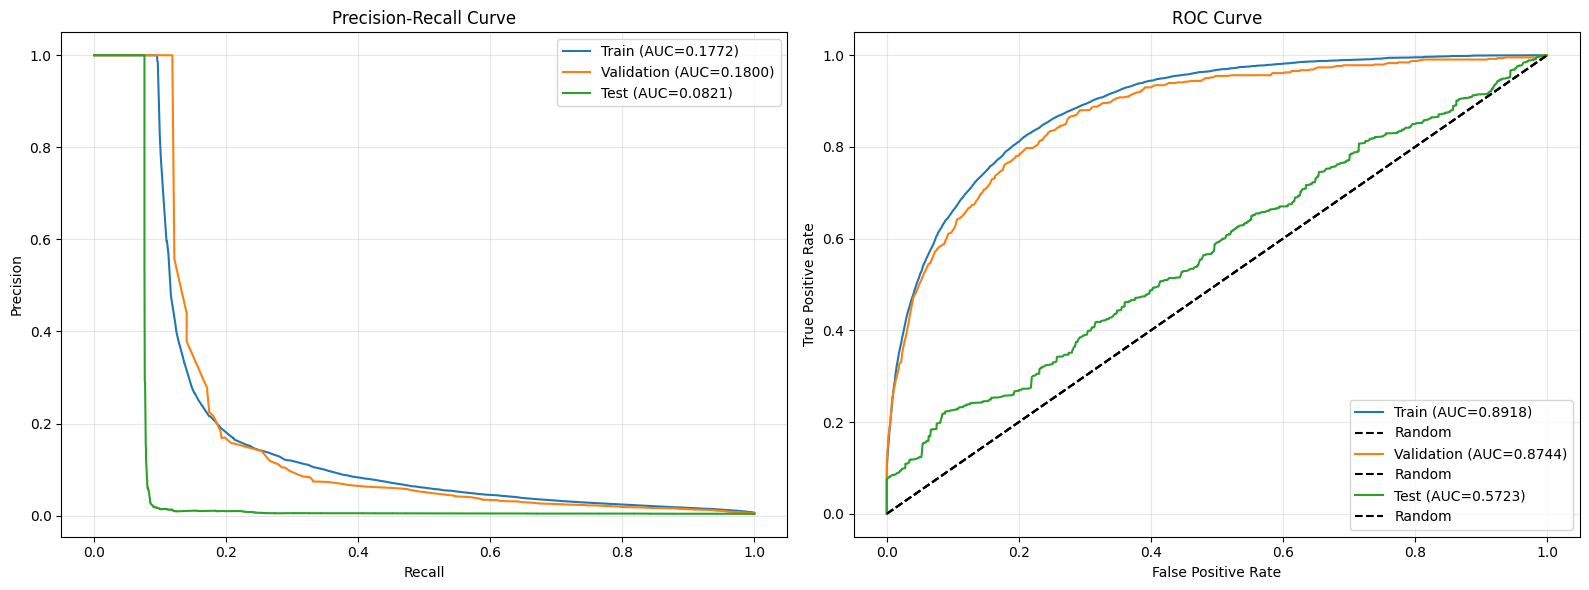

In [10]:
# ============================================================
# VISUALIZE BASELINE MODEL PERFORMANCE
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Precision-Recall curves
y_train_proba = baseline_model.predict_proba(X_train_baseline)[:, 1]
y_val_proba = baseline_model.predict_proba(X_val_baseline)[:, 1]
y_test_proba = baseline_model.predict_proba(X_test_baseline)[:, 1]

plot_precision_recall_curve(y_train_baseline, y_train_proba, "Train", axes[0])
plot_precision_recall_curve(y_val_baseline, y_val_proba, "Validation", axes[0])
plot_precision_recall_curve(y_test_baseline, y_test_proba, "Test", axes[0])

# ROC curves
plot_roc_curve(y_train_baseline, y_train_proba, "Train", axes[1])
plot_roc_curve(y_val_baseline, y_val_proba, "Validation", axes[1])
plot_roc_curve(y_test_baseline, y_test_proba, "Test", axes[1])

plt.tight_layout()
plt.show()

Baseline Model Feature Importance:
              feature  importance
transaction_count_bin    0.359592
          is_new_card    0.292863
   is_low_volume_card    0.158756
             time_bin    0.092117
   is_peak_fraud_hour    0.040383
                 hour    0.034355
         card_age_bin    0.021934


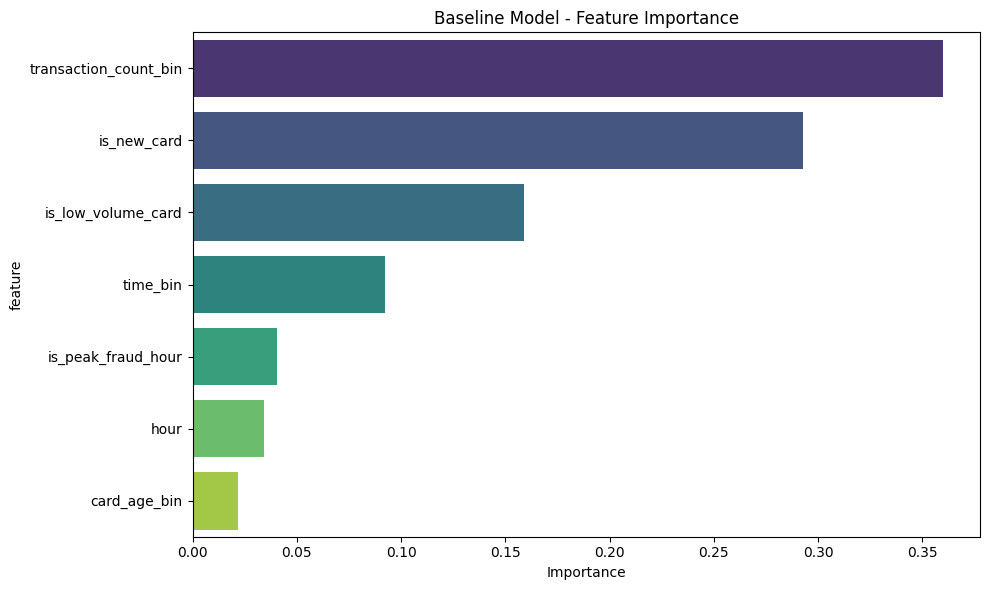


✓ Baseline model evaluation complete


In [11]:
# ============================================================
# FEATURE IMPORTANCE ANALYSIS (BASELINE)
# ============================================================

feature_importance = baseline_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': baseline_features,
    'importance': feature_importance
}).sort_values('importance', ascending=False)
importance_df = importance_df.copy()
importance_df['feature'] = display_feature_names(importance_df['feature'].tolist())

print("Baseline Model Feature Importance:")
print(importance_df.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
plt.title('Baseline Model - Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Store baseline results
baseline_results = {
    'features': baseline_features,
    'train_metrics': baseline_train_metrics,
    'val_metrics': baseline_val_metrics,
    'test_metrics': baseline_test_metrics,
    'feature_importance': importance_df.to_dict('records')
}

print("\n✓ Baseline model evaluation complete")

## 5. Iterative Feature Addition

In [12]:
# ============================================================
# ITERATIVE FEATURE ADDITION FUNCTION
# ============================================================

def train_and_evaluate_model(
    features: List[str],
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    scale_pos_weight: float
) -> Tuple[xgb.XGBClassifier, Dict[str, Dict[str, float]], pd.DataFrame]:
    """
    Train XGBoost model with given features and return metrics.
    Uses threshold tuning on validation set for better test metrics.
    
    Returns:
        Tuple of (model, metrics_dict, feature_importance_df)
    """
    # Prepare data
    X_train = train_df[features].values
    y_train = train_df['is_fraud'].values
    X_val = val_df[features].values
    y_val = val_df['is_fraud'].values
    X_test = test_df[features].values
    y_test = test_df['is_fraud'].values
    
    # Train model
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Find optimal threshold on validation set (maximize F1)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    best_thresh, best_val_f1 = find_best_threshold(y_val, y_val_proba, metric='f1')
    print(f"  Optimal threshold (max val F1): {best_thresh:.4f}")
    
    # Evaluate at default threshold (for comparison)
    print("\n  --- Metrics at default threshold (0.5) ---")
    train_metrics_default = evaluate_model(model, X_train, y_train, "Train")
    val_metrics_default = evaluate_model(model, X_val, y_val, "Validation")
    test_metrics_default = evaluate_model(model, X_test, y_test, "Test")
    
    # Evaluate at optimal threshold
    print(f"\n  --- Metrics at optimal threshold ({best_thresh:.4f}) ---")
    train_metrics = evaluate_model(model, X_train, y_train, "Train", threshold=best_thresh)
    val_metrics = evaluate_model(model, X_val, y_val, "Validation", threshold=best_thresh)
    test_metrics = evaluate_model(model, X_test, y_test, "Test", threshold=best_thresh)
    
    # Store optimal threshold in metrics
    metrics = {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics,
        'optimal_threshold': best_thresh,
        'train_default': train_metrics_default,
        'val_default': val_metrics_default,
        'test_default': test_metrics_default
    }
    
    # Feature importance
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return model, metrics, importance_df

print("Iterative feature addition function defined (with threshold tuning)")

Iterative feature addition function defined (with threshold tuning)


In [13]:
# ============================================================
# ITERATIVE FEATURE ADDITION: BUILD FEATURE SETS
# ============================================================

# Build progressive feature sets from feature_cols (Section 1)
n_total = len(feature_cols)
step_sizes = [k for k in (3, 5, 7, 10, 15, 20, n_total) if k <= n_total and k >= 1]
step_sizes = sorted(set(step_sizes))

feature_sets = []
for k in step_sizes:
    feats = feature_cols[:k]
    name = f"Top {k}" if k < n_total else "All"
    feature_sets.append({"name": name, "features": feats})

print(f"Feature addition sequence ({len(feature_sets)} steps):")
for i, fs in enumerate(feature_sets, 1):
    print(f"  Step {i}: {fs['name']} ({len(fs['features'])} features)")

Feature addition sequence (7 steps):
  Step 1: Top 3 (3 features)
  Step 2: Top 5 (5 features)
  Step 3: Top 7 (7 features)
  Step 4: Top 10 (10 features)
  Step 5: Top 15 (15 features)
  Step 6: Top 20 (20 features)
  Step 7: All (24 features)


In [14]:
# ============================================================
# ITERATIVE FEATURE ADDITION: TRAIN MODELS
# ============================================================

all_results = []
all_models = []

print("=" * 80)
print("ITERATIVE FEATURE ADDITION")
print("=" * 80)

for i, feature_set in enumerate(feature_sets):
    print(f"\n{'='*80}")
    print(f"Step {i+1}/{len(feature_sets)}: {feature_set['name']}")
    print(f"{'='*80}")
    print(f"Features ({len(feature_set['features'])}): {display_feature_names(feature_set['features'])}")
    
    # Train and evaluate
    model, metrics, importance_df = train_and_evaluate_model(
        feature_set['features'],
        train_df,
        val_df,
        test_df,
        scale_pos_weight
    )
    importance_df = importance_df.copy()
    importance_df['feature'] = display_feature_names(importance_df['feature'].tolist())
    
    # Store results
    result = {
        'step': i + 1,
        'name': feature_set['name'],
        'n_features': len(feature_set['features']),
        'features': feature_set['features'],
        'metrics': metrics,
        'feature_importance': importance_df,
        'model': model
    }
    
    all_results.append(result)
    all_models.append(model)
    
    # Print improvement over previous step
    if i > 0:
        prev_val_f1 = all_results[i-1]['metrics']['val']['f1_score']
        curr_val_f1 = metrics['val']['f1_score']
        improvement = curr_val_f1 - prev_val_f1
        print(f"\n  Improvement in Validation F1: {improvement:+.4f} ({improvement/prev_val_f1*100:+.2f}%)")

print(f"\n{'='*80}")
print("ITERATIVE FEATURE ADDITION COMPLETE")
print(f"{'='*80}")

ITERATIVE FEATURE ADDITION

Step 1/7: Top 3
Features (3): ['transaction_count_bin', 'card_age_bin', 'hour']


  Optimal threshold (max val F1): 1.0000

  --- Metrics at default threshold (0.5) ---



Train Performance:
  F1-Score: 0.0327
  Precision: 0.0168
  Recall: 0.6766
  ROC-AUC: 0.7900
  PR-AUC: 0.1142

  Confusion Matrix:
    TN: 792,793  FP: 236,236
    FN: 1,927  TP: 4,031
    False Positive Rate: 22.9572%

Validation Performance:
  F1-Score: 0.0361
  Precision: 0.0186
  Recall: 0.6641
  ROC-AUC: 0.7908
  PR-AUC: 0.1311

  Confusion Matrix:
    TN: 99,261  FP: 22,576
    FN: 216  TP: 427
    False Positive Rate: 18.5297%



Test Performance:
  F1-Score: 0.0105
  Precision: 0.0053
  Recall: 0.6056
  ROC-AUC: 0.6374
  PR-AUC: 0.0827

  Confusion Matrix:
    TN: 310,514  FP: 243,060
    FN: 846  TP: 1,299
    False Positive Rate: 43.9074%

  --- Metrics at optimal threshold (1.0000) ---



Train Performance: (threshold=1.0000)
  F1-Score: 0.1738
  Precision: 1.0000
  Recall: 0.0952
  ROC-AUC: 0.7900
  PR-AUC: 0.1142

  Confusion Matrix:
    TN: 1,029,029  FP: 0
    FN: 5,391  TP: 567
    False Positive Rate: 0.0000%

Validation Performance: (threshold=1.0000)
  F1-Score: 0.2114
  Precision: 1.0000
  Recall: 0.1182
  ROC-AUC: 0.7908
  PR-AUC: 0.1311

  Confusion Matrix:
    TN: 121,837  FP: 0
    FN: 567  TP: 76
    False Positive Rate: 0.0000%



Test Performance: (threshold=1.0000)
  F1-Score: 0.1412
  Precision: 1.0000
  Recall: 0.0760
  ROC-AUC: 0.6374
  PR-AUC: 0.0827

  Confusion Matrix:
    TN: 553,574  FP: 0
    FN: 1,982  TP: 163
    False Positive Rate: 0.0000%

Step 2/7: Top 5
Features (5): ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour']


  Optimal threshold (max val F1): 0.9997

  --- Metrics at default threshold (0.5) ---



Train Performance:
  F1-Score: 0.0411
  Precision: 0.0211
  Recall: 0.8031
  ROC-AUC: 0.8729
  PR-AUC: 0.1595

  Confusion Matrix:
    TN: 806,824  FP: 222,205
    FN: 1,173  TP: 4,785
    False Positive Rate: 21.5937%

Validation Performance:
  F1-Score: 0.0389
  Precision: 0.0200
  Recall: 0.7652
  ROC-AUC: 0.8633
  PR-AUC: 0.1665

  Confusion Matrix:
    TN: 97,688  FP: 24,149
    FN: 151  TP: 492
    False Positive Rate: 19.8207%



Test Performance:
  F1-Score: 0.0126
  Precision: 0.0064
  Recall: 0.5739
  ROC-AUC: 0.6974
  PR-AUC: 0.0934

  Confusion Matrix:
    TN: 361,379  FP: 192,195
    FN: 914  TP: 1,231
    False Positive Rate: 34.7189%

  --- Metrics at optimal threshold (0.9997) ---



Train Performance: (threshold=0.9997)
  F1-Score: 0.1735
  Precision: 1.0000
  Recall: 0.0950
  ROC-AUC: 0.8729
  PR-AUC: 0.1595

  Confusion Matrix:
    TN: 1,029,029  FP: 0
    FN: 5,392  TP: 566
    False Positive Rate: 0.0000%

Validation Performance: (threshold=0.9997)
  F1-Score: 0.2114
  Precision: 1.0000
  Recall: 0.1182
  ROC-AUC: 0.8633
  PR-AUC: 0.1665

  Confusion Matrix:
    TN: 121,837  FP: 0
    FN: 567  TP: 76
    False Positive Rate: 0.0000%



Test Performance: (threshold=0.9997)
  F1-Score: 0.1412
  Precision: 1.0000
  Recall: 0.0760
  ROC-AUC: 0.6974
  PR-AUC: 0.0934

  Confusion Matrix:
    TN: 553,574  FP: 0
    FN: 1,982  TP: 163
    False Positive Rate: 0.0000%

  Improvement in Validation F1: +0.0000 (+0.00%)

Step 3/7: Top 7
Features (7): ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card']


  Optimal threshold (max val F1): 0.9433

  --- Metrics at default threshold (0.5) ---



Train Performance:
  F1-Score: 0.0421
  Precision: 0.0216
  Recall: 0.8306
  ROC-AUC: 0.8918
  PR-AUC: 0.1772

  Confusion Matrix:
    TN: 804,678  FP: 224,351
    FN: 1,009  TP: 4,949
    False Positive Rate: 21.8022%

Validation Performance:
  F1-Score: 0.0398
  Precision: 0.0204
  Recall: 0.7807
  ROC-AUC: 0.8744
  PR-AUC: 0.1800

  Confusion Matrix:
    TN: 97,740  FP: 24,097
    FN: 141  TP: 502
    False Positive Rate: 19.7781%



Test Performance:
  F1-Score: 0.0099
  Precision: 0.0050
  Recall: 0.3748
  ROC-AUC: 0.5723
  PR-AUC: 0.0821

  Confusion Matrix:
    TN: 394,740  FP: 158,834
    FN: 1,341  TP: 804
    False Positive Rate: 28.6925%

  --- Metrics at optimal threshold (0.9433) ---



Train Performance: (threshold=0.9433)
  F1-Score: 0.1931
  Precision: 0.2794
  Recall: 0.1475
  ROC-AUC: 0.8918
  PR-AUC: 0.1772

  Confusion Matrix:
    TN: 1,026,762  FP: 2,267
    FN: 5,079  TP: 879
    False Positive Rate: 0.2203%

Validation Performance: (threshold=0.9433)
  F1-Score: 0.2123
  Precision: 0.4390
  Recall: 0.1400
  ROC-AUC: 0.8744
  PR-AUC: 0.1800

  Confusion Matrix:
    TN: 121,722  FP: 115
    FN: 553  TP: 90
    False Positive Rate: 0.0944%



Test Performance: (threshold=0.9433)
  F1-Score: 0.0962
  Precision: 0.1248
  Recall: 0.0783
  ROC-AUC: 0.5723
  PR-AUC: 0.0821

  Confusion Matrix:
    TN: 552,396  FP: 1,178
    FN: 1,977  TP: 168
    False Positive Rate: 0.2128%

  Improvement in Validation F1: +0.0009 (+0.41%)

Step 4/7: Top 10
Features (10): ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card', 'category', 'day_of_week', 'month']


  Optimal threshold (max val F1): 0.9375

  --- Metrics at default threshold (0.5) ---



Train Performance:
  F1-Score: 0.0431
  Precision: 0.0221
  Recall: 0.8359
  ROC-AUC: 0.8956
  PR-AUC: 0.1796

  Confusion Matrix:
    TN: 808,924  FP: 220,105
    FN: 978  TP: 4,980
    False Positive Rate: 21.3896%

Validation Performance:
  F1-Score: 0.0394
  Precision: 0.0202
  Recall: 0.7698
  ROC-AUC: 0.8745
  PR-AUC: 0.1805

  Confusion Matrix:
    TN: 97,842  FP: 23,995
    FN: 148  TP: 495
    False Positive Rate: 19.6943%



Test Performance:
  F1-Score: 0.0099
  Precision: 0.0050
  Recall: 0.3897
  ROC-AUC: 0.5913
  PR-AUC: 0.0830

  Confusion Matrix:
    TN: 387,888  FP: 165,686
    FN: 1,309  TP: 836
    False Positive Rate: 29.9302%

  --- Metrics at optimal threshold (0.9375) ---



Train Performance: (threshold=0.9375)
  F1-Score: 0.1930
  Precision: 0.2156
  Recall: 0.1747
  ROC-AUC: 0.8956
  PR-AUC: 0.1796

  Confusion Matrix:
    TN: 1,025,242  FP: 3,787
    FN: 4,917  TP: 1,041
    False Positive Rate: 0.3680%

Validation Performance: (threshold=0.9375)
  F1-Score: 0.2118
  Precision: 0.2961
  Recall: 0.1649
  ROC-AUC: 0.8745
  PR-AUC: 0.1805

  Confusion Matrix:
    TN: 121,585  FP: 252
    FN: 537  TP: 106
    False Positive Rate: 0.2068%



Test Performance: (threshold=0.9375)
  F1-Score: 0.0862
  Precision: 0.0944
  Recall: 0.0793
  ROC-AUC: 0.5913
  PR-AUC: 0.0830

  Confusion Matrix:
    TN: 551,944  FP: 1,630
    FN: 1,975  TP: 170
    False Positive Rate: 0.2945%

  Improvement in Validation F1: -0.0005 (-0.22%)

Step 5/7: Top 15
Features (15): ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card', 'category', 'day_of_week', 'month', 'is_peak_fraud_day', 'is_peak_fraud_season', 'is_high_risk_category', 'card_age_days', 'transaction_count']


  Optimal threshold (max val F1): 0.9988

  --- Metrics at default threshold (0.5) ---



Train Performance:
  F1-Score: 0.0482
  Precision: 0.0248
  Recall: 0.8573
  ROC-AUC: 0.9128
  PR-AUC: 0.2007

  Confusion Matrix:
    TN: 827,991  FP: 201,038
    FN: 850  TP: 5,108
    False Positive Rate: 19.5367%

Validation Performance:
  F1-Score: 0.0752
  Precision: 0.0407
  Recall: 0.4992
  ROC-AUC: 0.8514
  PR-AUC: 0.1697

  Confusion Matrix:
    TN: 114,262  FP: 7,575
    FN: 322  TP: 321
    False Positive Rate: 6.2173%



Test Performance:
  F1-Score: 0.0147
  Precision: 0.0076
  Recall: 0.2937
  ROC-AUC: 0.6223
  PR-AUC: 0.0827

  Confusion Matrix:
    TN: 470,773  FP: 82,801
    FN: 1,515  TP: 630
    False Positive Rate: 14.9575%

  --- Metrics at optimal threshold (0.9988) ---



Train Performance: (threshold=0.9988)
  F1-Score: 0.1735
  Precision: 1.0000
  Recall: 0.0950
  ROC-AUC: 0.9128
  PR-AUC: 0.2007

  Confusion Matrix:
    TN: 1,029,029  FP: 0
    FN: 5,392  TP: 566
    False Positive Rate: 0.0000%

Validation Performance: (threshold=0.9988)
  F1-Score: 0.2114
  Precision: 1.0000
  Recall: 0.1182
  ROC-AUC: 0.8514
  PR-AUC: 0.1697

  Confusion Matrix:
    TN: 121,837  FP: 0
    FN: 567  TP: 76
    False Positive Rate: 0.0000%



Test Performance: (threshold=0.9988)
  F1-Score: 0.1412
  Precision: 1.0000
  Recall: 0.0760
  ROC-AUC: 0.6223
  PR-AUC: 0.0827

  Confusion Matrix:
    TN: 553,574  FP: 0
    FN: 1,982  TP: 163
    False Positive Rate: 0.0000%

  Improvement in Validation F1: -0.0004 (-0.18%)

Step 6/7: Top 20
Features (20): ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card', 'category', 'day_of_week', 'month', 'is_peak_fraud_day', 'is_peak_fraud_season', 'is_high_risk_category', 'card_age_days', 'transaction_count', 'evening_high_amount', 'evening_online_shopping', 'large_city_evening', 'new_card_evening', 'high_amount_online']


  Optimal threshold (max val F1): 0.9611

  --- Metrics at default threshold (0.5) ---



Train Performance:
  F1-Score: 0.0906
  Precision: 0.0478
  Recall: 0.8736
  ROC-AUC: 0.9578
  PR-AUC: 0.5185

  Confusion Matrix:
    TN: 925,273  FP: 103,756
    FN: 753  TP: 5,205
    False Positive Rate: 10.0829%

Validation Performance:
  F1-Score: 0.0895
  Precision: 0.0483
  Recall: 0.6174
  ROC-AUC: 0.8866
  PR-AUC: 0.4538

  Confusion Matrix:
    TN: 114,009  FP: 7,828
    FN: 246  TP: 397
    False Positive Rate: 6.4250%



Test Performance:
  F1-Score: 0.0164
  Precision: 0.0083
  Recall: 0.5492
  ROC-AUC: 0.7168
  PR-AUC: 0.2074

  Confusion Matrix:
    TN: 413,345  FP: 140,229
    FN: 967  TP: 1,178
    False Positive Rate: 25.3316%

  --- Metrics at optimal threshold (0.9611) ---



Train Performance: (threshold=0.9611)
  F1-Score: 0.5224
  Precision: 0.6800
  Recall: 0.4241
  ROC-AUC: 0.9578
  PR-AUC: 0.5185

  Confusion Matrix:
    TN: 1,027,840  FP: 1,189
    FN: 3,431  TP: 2,527
    False Positive Rate: 0.1155%

Validation Performance: (threshold=0.9611)
  F1-Score: 0.5513
  Precision: 0.7421
  Recall: 0.4386
  ROC-AUC: 0.8866
  PR-AUC: 0.4538

  Confusion Matrix:
    TN: 121,739  FP: 98
    FN: 361  TP: 282
    False Positive Rate: 0.0804%



Test Performance: (threshold=0.9611)
  F1-Score: 0.3028
  Precision: 0.3631
  Recall: 0.2597
  ROC-AUC: 0.7168
  PR-AUC: 0.2074

  Confusion Matrix:
    TN: 552,597  FP: 977
    FN: 1,588  TP: 557
    False Positive Rate: 0.1765%

  Improvement in Validation F1: +0.3399 (+160.79%)

Step 7/7: All
Features (24): ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card', 'category', 'day_of_week', 'month', 'is_peak_fraud_day', 'is_peak_fraud_season', 'is_high_risk_category', 'card_age_days', 'transaction_count', 'evening_high_amount', 'evening_online_shopping', 'large_city_evening', 'new_card_evening', 'high_amount_online', 'temporal_risk_score', 'geographic_risk_score', 'card_risk_score', 'risk_tier']


  Optimal threshold (max val F1): 0.9588

  --- Metrics at default threshold (0.5) ---



Train Performance:
  F1-Score: 0.1057
  Precision: 0.0562
  Recall: 0.8790
  ROC-AUC: 0.9656
  PR-AUC: 0.6004

  Confusion Matrix:
    TN: 941,089  FP: 87,940
    FN: 721  TP: 5,237
    False Positive Rate: 8.5459%

Validation Performance:
  F1-Score: 0.0979
  Precision: 0.0528
  Recall: 0.6703
  ROC-AUC: 0.9102
  PR-AUC: 0.4834

  Confusion Matrix:
    TN: 114,102  FP: 7,735
    FN: 212  TP: 431
    False Positive Rate: 6.3486%



Test Performance:
  F1-Score: 0.0216
  Precision: 0.0110
  Recall: 0.5520
  ROC-AUC: 0.7641
  PR-AUC: 0.1896

  Confusion Matrix:
    TN: 447,431  FP: 106,143
    FN: 961  TP: 1,184
    False Positive Rate: 19.1741%

  --- Metrics at optimal threshold (0.9588) ---



Train Performance: (threshold=0.9588)
  F1-Score: 0.6028
  Precision: 0.6644
  Recall: 0.5517
  ROC-AUC: 0.9656
  PR-AUC: 0.6004

  Confusion Matrix:
    TN: 1,027,369  FP: 1,660
    FN: 2,671  TP: 3,287
    False Positive Rate: 0.1613%

Validation Performance: (threshold=0.9588)
  F1-Score: 0.5469
  Precision: 0.6429
  Recall: 0.4759
  ROC-AUC: 0.9102
  PR-AUC: 0.4834

  Confusion Matrix:
    TN: 121,667  FP: 170
    FN: 337  TP: 306
    False Positive Rate: 0.1395%



Test Performance: (threshold=0.9588)
  F1-Score: 0.2917
  Precision: 0.2620
  Recall: 0.3291
  ROC-AUC: 0.7641
  PR-AUC: 0.1896

  Confusion Matrix:
    TN: 551,585  FP: 1,989
    FN: 1,439  TP: 706
    False Positive Rate: 0.3593%

  Improvement in Validation F1: -0.0044 (-0.80%)

ITERATIVE FEATURE ADDITION COMPLETE



Model Performance Comparison (at optimal threshold):
Feature Set  N Features  Threshold  Train F1   Val F1  Test F1  Val PR-AUC  Test PR-AUC  Val ROC-AUC  Test ROC-AUC  Test Precision  Test Recall
      Top 3           3   0.999970  0.173793 0.211405 0.141248    0.131113     0.082747     0.790821      0.637368        1.000000     0.075991
      Top 5           5   0.999678  0.173513 0.211405 0.141248    0.166467     0.093399     0.863298      0.697375        1.000000     0.075991
      Top 7           7   0.943307  0.193102 0.212264 0.096247    0.180022     0.082069     0.874406      0.572252        0.124814     0.078322
     Top 10          10   0.937454  0.193028 0.211788 0.086185    0.180523     0.083043     0.874549      0.591306        0.094444     0.079254
     Top 15          15   0.998780  0.173513 0.211405 0.141248    0.169720     0.082693     0.851419      0.622295        1.000000     0.075991
     Top 20          20   0.961079  0.522431 0.551320 0.302800    0.453760     0.2

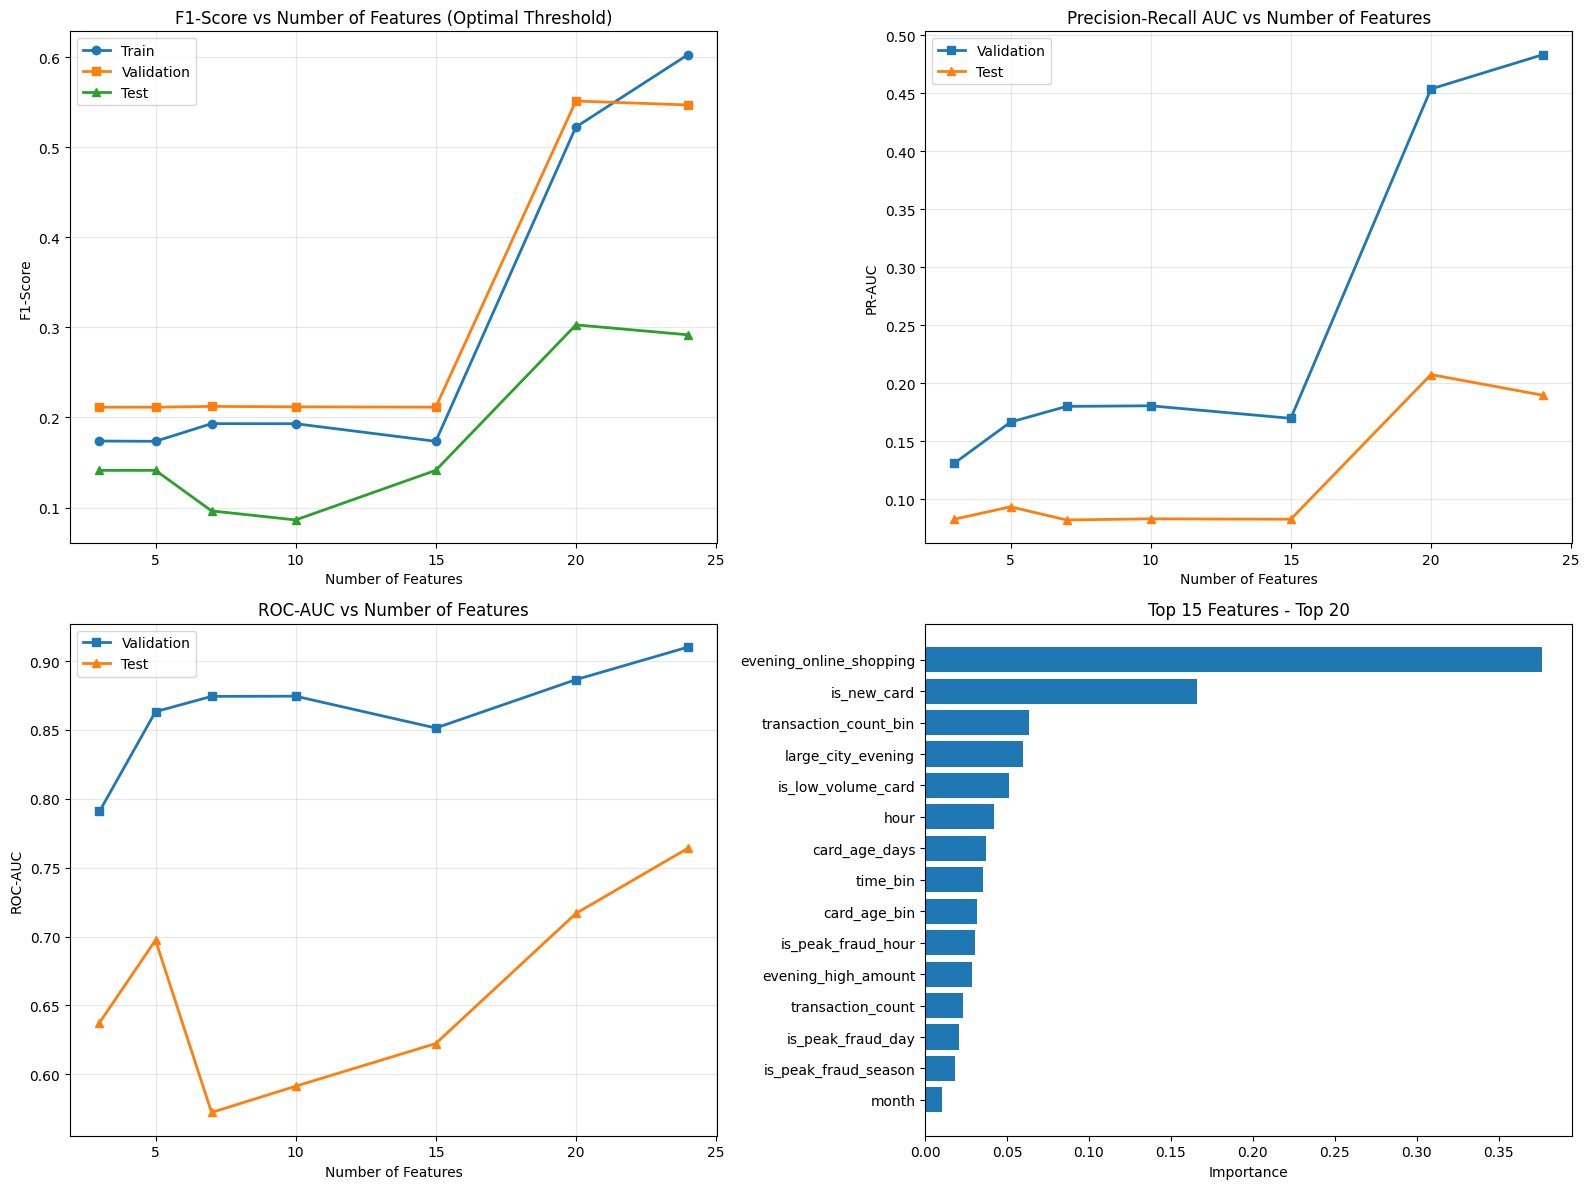

In [15]:
# ============================================================
# COMPARE MODEL PERFORMANCE ACROSS FEATURE SETS
# ============================================================

# Create comparison DataFrame with optimal threshold metrics
comparison_data = []
for result in all_results:
    comparison_data.append({
        'Feature Set': result['name'],
        'N Features': result['n_features'],
        'Threshold': result['metrics'].get('optimal_threshold', 0.5),
        'Train F1': result['metrics']['train']['f1_score'],
        'Val F1': result['metrics']['val']['f1_score'],
        'Test F1': result['metrics']['test']['f1_score'],
        'Val PR-AUC': result['metrics']['val']['pr_auc'],
        'Test PR-AUC': result['metrics']['test']['pr_auc'],
        'Val ROC-AUC': result['metrics']['val']['roc_auc'],
        'Test ROC-AUC': result['metrics']['test']['roc_auc'],
        'Test Precision': result['metrics']['test']['precision'],
        'Test Recall': result['metrics']['test']['recall']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison (at optimal threshold):")
print(comparison_df.to_string(index=False))

# Visualize performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1-Score comparison
axes[0, 0].plot(comparison_df['N Features'], comparison_df['Train F1'], 'o-', label='Train', linewidth=2)
axes[0, 0].plot(comparison_df['N Features'], comparison_df['Val F1'], 's-', label='Validation', linewidth=2)
axes[0, 0].plot(comparison_df['N Features'], comparison_df['Test F1'], '^-', label='Test', linewidth=2)
axes[0, 0].set_xlabel('Number of Features')
axes[0, 0].set_ylabel('F1-Score')
axes[0, 0].set_title('F1-Score vs Number of Features (Optimal Threshold)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# PR-AUC comparison
axes[0, 1].plot(comparison_df['N Features'], comparison_df['Val PR-AUC'], 's-', label='Validation', linewidth=2)
axes[0, 1].plot(comparison_df['N Features'], comparison_df['Test PR-AUC'], '^-', label='Test', linewidth=2)
axes[0, 1].set_xlabel('Number of Features')
axes[0, 1].set_ylabel('PR-AUC')
axes[0, 1].set_title('Precision-Recall AUC vs Number of Features')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# ROC-AUC comparison
axes[1, 0].plot(comparison_df['N Features'], comparison_df['Val ROC-AUC'], 's-', label='Validation', linewidth=2)
axes[1, 0].plot(comparison_df['N Features'], comparison_df['Test ROC-AUC'], '^-', label='Test', linewidth=2)
axes[1, 0].set_xlabel('Number of Features')
axes[1, 0].set_ylabel('ROC-AUC')
axes[1, 0].set_title('ROC-AUC vs Number of Features')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Feature importance for best model (highest validation F1)
best_idx = comparison_df['Val F1'].idxmax()
best_result = all_results[best_idx]
importance_df_best = best_result['feature_importance'].head(15)

axes[1, 1].barh(range(len(importance_df_best)), importance_df_best['importance'].values)
axes[1, 1].set_yticks(range(len(importance_df_best)))
axes[1, 1].set_yticklabels(importance_df_best['feature'].values)
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title(f'Top 15 Features - {best_result["name"]}')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

In [16]:
# ============================================================
# IDENTIFY BEST MODEL
# ============================================================

# Find best model based on validation F1-score
best_idx = comparison_df['Val F1'].idxmax()
best_result = all_results[best_idx]
best_model = best_result['model']

print("=" * 80)
print("BEST MODEL SELECTION")
print("=" * 80)
print(f"\nBest Model: {best_result['name']}")
print(f"  Number of Features: {best_result['n_features']}")
print(f"  Optimal Threshold: {best_result['metrics'].get('optimal_threshold', 0.5):.4f}")
print(f"\nValidation Performance (at optimal threshold):")
print(f"  F1-Score: {best_result['metrics']['val']['f1_score']:.4f}")
print(f"  Precision: {best_result['metrics']['val']['precision']:.4f}")
print(f"  Recall: {best_result['metrics']['val']['recall']:.4f}")
print(f"  PR-AUC: {best_result['metrics']['val']['pr_auc']:.4f}")
print(f"  ROC-AUC: {best_result['metrics']['val']['roc_auc']:.4f}")
print(f"\nTest Performance (at optimal threshold):")
print(f"  F1-Score: {best_result['metrics']['test']['f1_score']:.4f}")
print(f"  Precision: {best_result['metrics']['test']['precision']:.4f}")
print(f"  Recall: {best_result['metrics']['test']['recall']:.4f}")
print(f"  PR-AUC: {best_result['metrics']['test']['pr_auc']:.4f}")
print(f"  ROC-AUC: {best_result['metrics']['test']['roc_auc']:.4f}")

print(f"\nTop 10 Most Important Features:")
print(best_result['feature_importance'].head(10).to_string(index=False))

BEST MODEL SELECTION

Best Model: Top 20
  Number of Features: 20
  Optimal Threshold: 0.9611

Validation Performance (at optimal threshold):
  F1-Score: 0.5513
  Precision: 0.7421
  Recall: 0.4386
  PR-AUC: 0.4538
  ROC-AUC: 0.8866

Test Performance (at optimal threshold):
  F1-Score: 0.3028
  Precision: 0.3631
  Recall: 0.2597
  PR-AUC: 0.2074
  ROC-AUC: 0.7168

Top 10 Most Important Features:
                feature  importance
evening_online_shopping    0.376264
            is_new_card    0.165893
  transaction_count_bin    0.063730
     large_city_evening    0.059574
     is_low_volume_card    0.051467
                   hour    0.042229
          card_age_days    0.037451
               time_bin    0.035181
           card_age_bin    0.031686
     is_peak_fraud_hour    0.030642


## 6. Save Best Model

In [17]:
# ============================================================
# SAVE BEST MODEL AND RESULTS
# ============================================================

# Save best model
model_path = MODELS_DIR / 'xgb_best_model.pkl'
joblib.dump(best_model, model_path)
print(f"Best model saved: {model_path}")

# Save model metadata including optimal threshold
model_metadata = {
    'model_name': best_result['name'],
    'features': best_result['features'],
    'n_features': best_result['n_features'],
    'optimal_threshold': best_result['metrics'].get('optimal_threshold', 0.5),
    'metrics': best_result['metrics'],
    'feature_importance': best_result['feature_importance'].to_dict('records'),
    'scale_pos_weight': scale_pos_weight,
    'training_date': datetime.now().isoformat()
}

metadata_path = MODELS_DIR / 'xgb_best_model_metadata.pkl'
joblib.dump(model_metadata, metadata_path)
print(f"Model metadata saved: {metadata_path}")

# Save all results for comparison
all_results_path = RESULTS_DIR / 'iterative_feature_addition_results.pkl'
joblib.dump(all_results, all_results_path)
print(f"All results saved: {all_results_path}")

# Save comparison DataFrame
comparison_df_path = RESULTS_DIR / 'model_comparison.csv'
comparison_df.to_csv(comparison_df_path, index=False)
print(f"Comparison DataFrame saved: {comparison_df_path}")

print("\nModel saving complete!")

Best model saved: /home/alireza/Desktop/projects/fraud-shield-ai/models/xgb_best_model.pkl
Model metadata saved: /home/alireza/Desktop/projects/fraud-shield-ai/models/xgb_best_model_metadata.pkl
All results saved: /home/alireza/Desktop/projects/fraud-shield-ai/results/iterative_feature_addition_results.pkl
Comparison DataFrame saved: /home/alireza/Desktop/projects/fraud-shield-ai/results/model_comparison.csv

Model saving complete!
